#### imports

In [ ]:
import os
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import shutil
import random
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as T
from torchvision.transforms import functional as TF
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import optuna

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CV Project: Classification of drone types by images

#### This project focuses on building a convolutional neural network (CNN) model for classifying images based on the presence and type of drone.

The model is trained to recognize four classes:
- **no_drone** – images without any drone
- **dji_mavic**
- **dji_phantom**
- **dji_inspire**

#### Dataset source:

https://www.kaggle.com/datasets/balajikartheek/drone-type-classification

#### Project objective:

Develop a strong image classifier for drone detection and type identification.

#### Author: Mariia Cherkasova

# Part I

## dataset overview

### folder structure & images overview

#### folder

In [20]:
ds_path = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset'

In [21]:
train_path = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/train'
val_path = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/val'

- whole folder

In [22]:
print(f'Sctucture {ds_path}:')
for item in os.listdir(ds_path):
  print(item)

Sctucture /kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset:
val
train


- train folder

In [23]:
print(f'Sctucture {train_path}:')
for item in os.listdir(train_path):
  print(item)

Sctucture /kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/train:
dji_inspire
dji_mavic
no_drone
dji_phantom


- validation folder

In [24]:
print(f'Sctucture {val_path}:')
for item in os.listdir(val_path):
  print(item)

Sctucture /kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/val:
dji_inspire
dji_mavic
no_drone
dji_phantom


as we can see, there's 4 classes in our dataset and it's already splitted for train and validation.

#### images info

- data type

In [25]:
train_png = 0
train_other = 0
val_png = 0
val_other = 0

In [26]:
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    for fname in os.listdir(class_dir):
        if fname.lower().endswith('.png'):
            train_png += 1
        else:
            train_other += 1

for class_name in os.listdir(val_path):
    class_dir = os.path.join(val_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    for fname in os.listdir(class_dir):
        if fname.lower().endswith('.png'):
            val_png += 1
        else:
            val_other += 1

In [27]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Train", "Validation"))
# train
fig.add_trace(
    go.Bar(x=['PNG', 'Other'], y=[train_png, train_other], name='Train'),
    row=1, col=1)
# val
fig.add_trace(
    go.Bar(x=['PNG', 'Other'], y=[val_png, val_other], name='Val'),
    row=1, col=2)
fig.update_layout(
    title_text='type of images (Train & Validation samples)',
    showlegend=False,
    height=400,
    width=800)
fig.update_yaxes(title_text="num", row=1, col=1)
fig.update_yaxes(title_text="num", row=1, col=2)
fig.show()

all images are PNG! so we won't do anything the data type.

- image format

In [28]:
image_sizes = set()

for folder in [train_path, val_path]:
    for class_name in os.listdir(folder):
        class_dir = os.path.join(folder, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            file_path = os.path.join(class_dir, fname)
            img = Image.open(file_path)
            image_sizes.add(img.size)

In [29]:
if len(image_sizes) == 1:
    print('all images have the same size', list(image_sizes)[0])
else:
    print('different image size:', image_sizes)

different image size: {(1901, 1080), (451, 451), (267, 267), (1243, 1080), (277, 277), (61, 61), (543, 543), (181, 181), (369, 369), (153, 153), (273, 273), (57, 57), (429, 429), (117, 117), (365, 365), (149, 149), (953, 953), (305, 305), (425, 425), (209, 209), (241, 241), (613, 613), (397, 397), (35, 35), (517, 517), (301, 301), (705, 705), (127, 127), (393, 393), (403, 403), (297, 297), (435, 435), (91, 91), (339, 339), (123, 123), (485, 485), (495, 495), (279, 279), (389, 389), (605, 605), (399, 399), (183, 183), (63, 63), (431, 431), (215, 215), (977, 977), (587, 587), (371, 371), (491, 491), (275, 275), (59, 59), (1631, 1080), (101, 101), (367, 367), (377, 377), (271, 271), (643, 643), (65, 65), (675, 675), (459, 459), (97, 97), (579, 579), (363, 363), (253, 253), (373, 373), (157, 157), (189, 189), (561, 561), (345, 345), (827, 827), (465, 465), (249, 249), (33, 33), (1331, 1080), (1463, 1080), (919, 919), (557, 557), (341, 341), (125, 125), (245, 245), (29, 29), (617, 617), (40

there's lots of different image sizes, let's visualize it.

In [15]:
widths = []
heights = []
labels = []

for folder, label in [(train_path, 'train'), (val_path, 'val')]:
    for class_name in os.listdir(folder):
        class_dir = os.path.join(folder, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            file_path = os.path.join(class_dir, fname)
            img = Image.open(file_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            labels.append(label)

In [ ]:
fig = px.scatter(
    x=widths,
    y=heights,
    color=labels,
    labels={'x': 'width', 'y': 'height'},
    title='image size distribution (Train & Validation samples)',)

fig.update_traces(marker=dict(size=6, opacity=0.6))
fig.update_layout(width=800, height=500)
fig.show()

most of images - squares, but not all of them. so we should definitely work on it

### class

let's see if the dataset is balanced by class.

In [33]:
def count_img(path):
    counts = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path) and not folder.startswith('.'):
            counts[folder] = len(os.listdir(folder_path))
    return counts

In [34]:
train_counts = count_img(train_path)
val_counts = count_img(val_path)

df_train = pd.DataFrame(list(train_counts.items()), columns=['class', 'count'])
df_val = pd.DataFrame(list(val_counts.items()), columns=['class', 'count'])

In [35]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Train', 'Validation'))

fig.add_trace(
    go.Bar(x=df_train['class'], y=df_train['count'], text=df_train['count'],
           name='Train'), row=1, col=1)

fig.add_trace(
    go.Bar(x=df_val['class'], y=df_val['count'], text=df_val['count'],
           name='Val', marker_color='#9467bd'), row=1, col=2)

fig.update_layout(
    title_text='num of images in each class (Train & Validation samples)',
    width=1000, height=500, showlegend=False)

fig.update_xaxes(title_text='class', tickangle=-45, row=1, col=1)
fig.update_xaxes(title_text='class', tickangle=-45, row=1, col=2)
fig.update_yaxes(title_text='num', row=1, col=1)
fig.update_yaxes(title_text='num', row=1, col=2)
fig.show()

so there's ~1000 per each class for both train and validation datasets.

perfect!

### train/val/test split

we already got train set with 4000 samples and validation set with 4000 samples.

let's make test and validation samples 50/50, we'll have 2000 samples for validation and 2000 samples for test.

In [36]:
paths_to_remove = ['/kaggle/working/val', '/kaggle/working/test']

for path in paths_to_remove:
    if os.path.exists(path):
        shutil.rmtree(path)

In [37]:
test_path = '/kaggle/working/test'
val_path = '/kaggle/working/val'
val_path1 = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/val'

In [38]:
for cls in os.listdir(val_path1):
    src = os.path.join(val_path1, cls)
    if not os.path.isdir(src):
        continue

    dst_val = os.path.join(val_path, cls)
    dst_test = os.path.join(test_path, cls)

    os.makedirs(dst_val, exist_ok=True)
    os.makedirs(dst_test, exist_ok=True)

    files = os.listdir(src)
    random.shuffle(files)

    split_idx = len(files) // 2
    val_files = files[:split_idx]
    test_files = files[split_idx:]

    for f in val_files:
        shutil.copy(os.path.join(src, f), os.path.join(dst_val, f))

    for f in test_files:
        shutil.copy(os.path.join(src, f), os.path.join(dst_test, f))

done!

In [39]:
test_counts = count_img(test_path)
val_counts = count_img(val_path)

df_test = pd.DataFrame(list(test_counts.items()), columns=['class', 'count'])
df_val = pd.DataFrame(list(val_counts.items()), columns=['class', 'count'])

In [40]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Test', 'Validation'))

fig.add_trace(
    go.Bar(x=df_train['class'], y=df_test['count'], text=df_test['count'],
           name='Test'), row=1, col=1)

fig.add_trace(
    go.Bar(x=df_val['class'], y=df_val['count'], text=df_val['count'],
           name='Val', marker_color='#9467bd'), row=1, col=2)

fig.update_layout(
    title_text='num of images in each class (Test & Validation samples)',
    width=1000, height=500, showlegend=False)

fig.update_xaxes(title_text='class', tickangle=-45, row=1, col=1)
fig.update_xaxes(title_text='class', tickangle=-45, row=1, col=2)
fig.update_yaxes(title_text='num', row=1, col=1)
fig.update_yaxes(title_text='num', row=1, col=2)
fig.show()

done!

## preparing the data

### images

first of all let's take a look on what images we're working with.

#### train samples

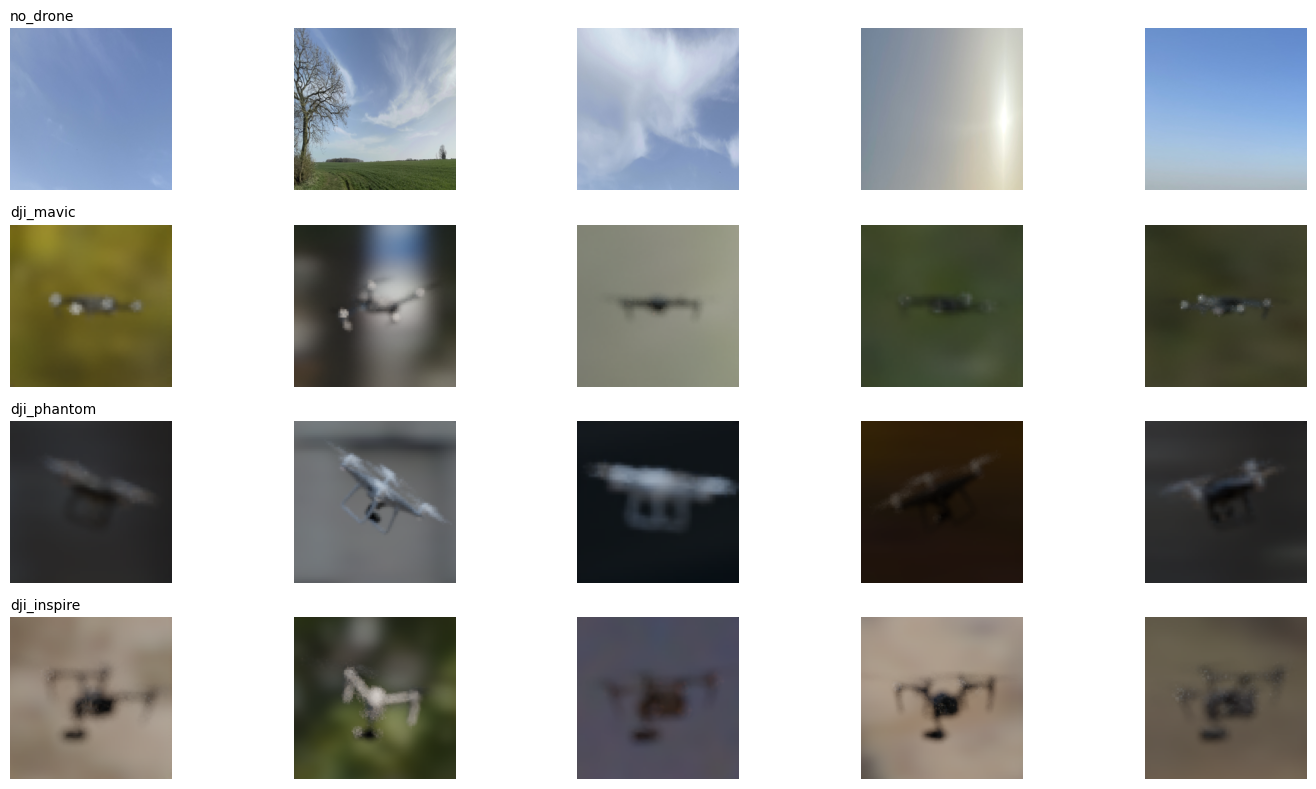

In [41]:
class_names = ['no_drone', 'dji_mavic', 'dji_phantom', 'dji_inspire']

fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, 8))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_path, class_name)
    image_files = [
        f for f in os.listdir(class_dir)
        if os.path.isfile(os.path.join(class_dir, f))]
    random_images = random.sample(image_files, k=5)
    for j, image_name in enumerate(random_images):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=10, loc='left')
plt.tight_layout()
plt.show()

#### validation samples

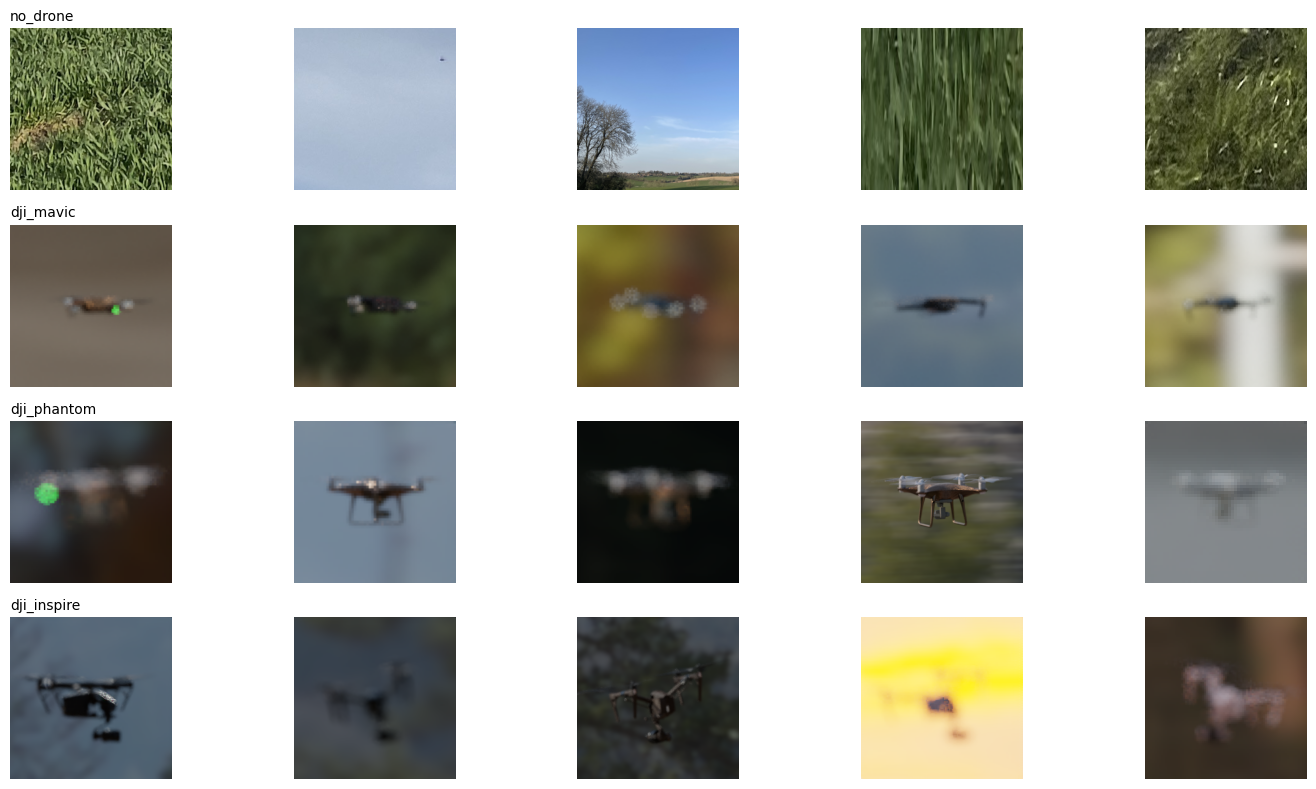

In [ ]:
fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, 8))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(val_path, class_name)
    image_files = [
        f for f in os.listdir(class_dir)
        if os.path.isfile(os.path.join(class_dir, f))]
    random_images = random.sample(image_files, k=5)
    for j, image_name in enumerate(random_images):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=10, loc='left')
plt.tight_layout()
plt.show()

#### test samples

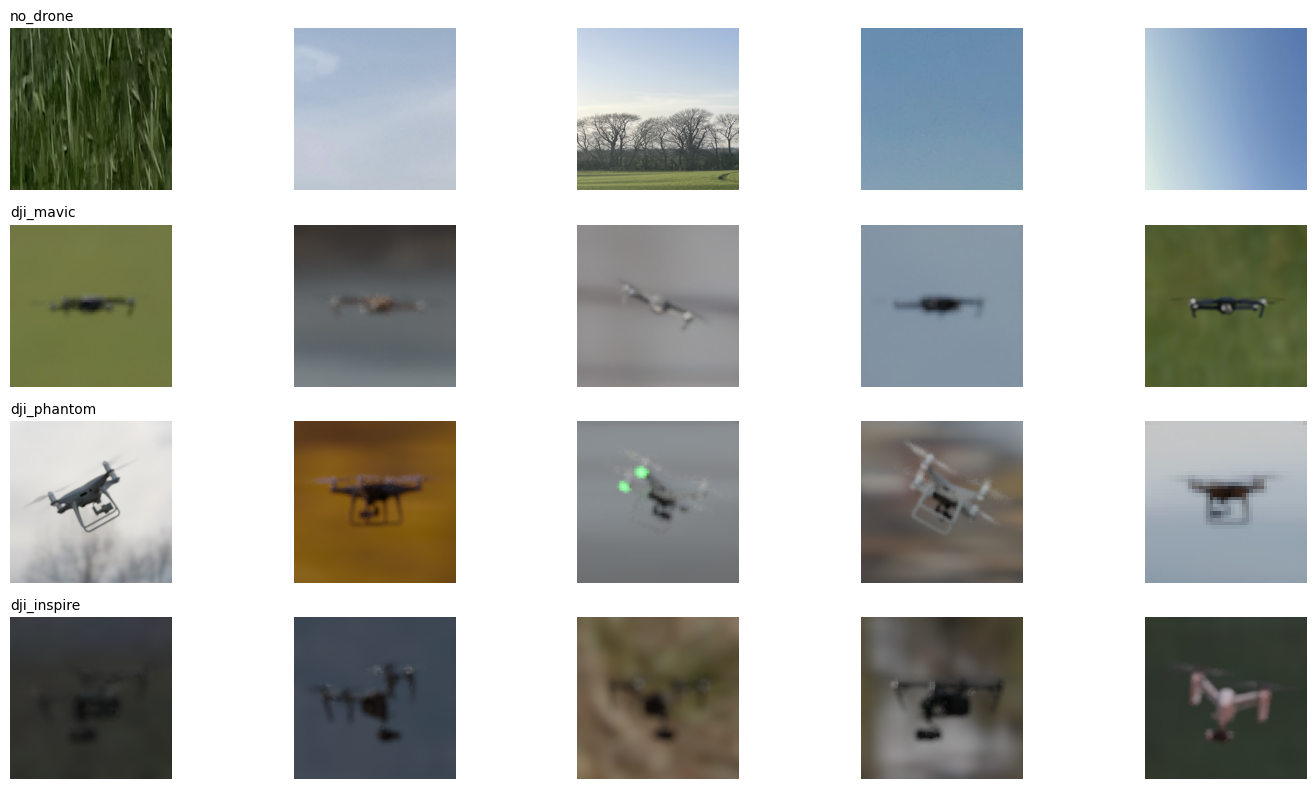

In [ ]:
fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, 8))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(test_path, class_name)
    image_files = [
        f for f in os.listdir(class_dir)
        if os.path.isfile(os.path.join(class_dir, f))]
    random_images = random.sample(image_files, k=5)
    for j, image_name in enumerate(random_images):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=10, loc='left')
plt.tight_layout()
plt.show()

We definitely can work with these images.

I was thinking if augmentation is worth using, cause we already got so many blurred images, and decides that we do need augmentation — but wisely, taking into account the characteristics of the dataset.

### padding

going back to the problem with different size of images. we got:
1.  square images but different sizes (60x60, 500x500 etc)
2. images with different width&height (1400x1080, 1500x1080)

for 2d images we'll use padding,

In [42]:
def pad_to_square(img, fill=127):
    w, h = img.size
    if w == h:
        return img
    max_wh = max(w, h)
    pad_left = (max_wh - w) // 2
    pad_top = (max_wh - h) // 2
    pad_right = max_wh - w - pad_left
    pad_bottom = max_wh - h - pad_top
    return TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=fill)

cheking if everything's working fine

In [43]:
image_path = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/train/dji_mavic/245.png'

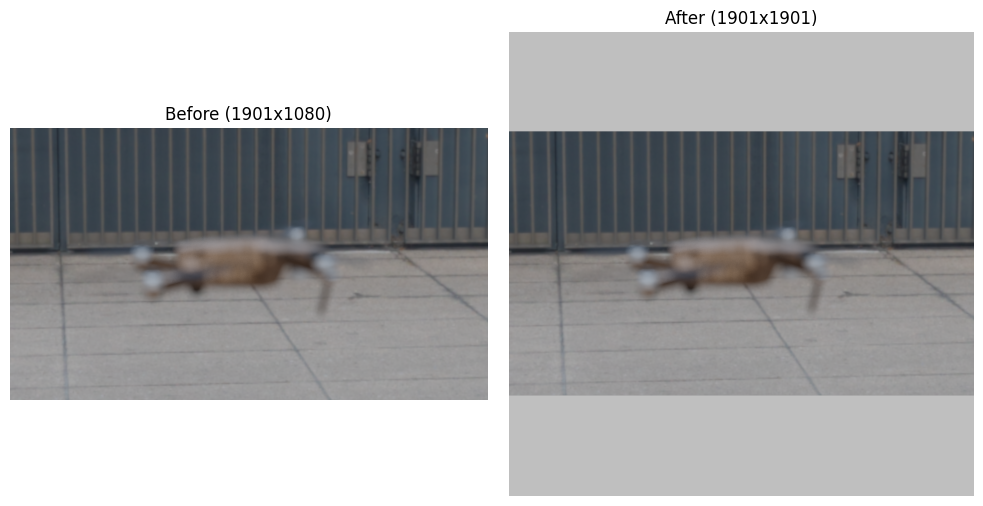

In [44]:
img = Image.open(image_path)
img_padded = pad_to_square(img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].set_title(f"Before ({img.size[0]}x{img.size[1]})")
axes[0].axis('off')
axes[1].imshow(img_padded)
axes[1].set_title(f"After ({img_padded.size[0]}x{img_padded.size[1]})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

cool! let's pad other images.

*saving padded dataset separately from original.

In [45]:
# copying train folder to working space
src_train = '/kaggle/input/drone-type-classification/Synthetic_Drone_Classification_Dataset/train'
train_path = '/kaggle/working/train'

if os.path.exists(train_path):
    shutil.rmtree(train_path)

shutil.copytree(src_train, train_path)

'/kaggle/working/train'

In [46]:
# new path
ds_path = '/kaggle/working/'
p_ds_path = '/kaggle/working/ds_padded'
subfolders = ['train', 'val', 'test']

done!

In [47]:
for split in subfolders:
    split_dir = os.path.join(ds_path, split)
    save_split_dir = os.path.join(p_ds_path, split)
    os.makedirs(save_split_dir, exist_ok=True)

    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        save_class_dir = os.path.join(save_split_dir, class_name)
        os.makedirs(save_class_dir, exist_ok=True)

        for fname in tqdm(os.listdir(class_dir), desc=f"{split}/{class_name}"):
            src_path = os.path.join(class_dir, fname)
            dst_path = os.path.join(save_class_dir, fname)
            img = Image.open(src_path)
            img_padded = pad_to_square(img)
            img_padded.save(dst_path)

test/no_drone: 100%|██████████| 500/500 [00:09<00:00, 52.76it/s]


let's give credit to this tqdm progress animation for keeping me from getting nervous!

now let's make sure that all images are squared.

In [48]:
widths = []
heights = []
labels = []

for split in subfolders:
    split_path = os.path.join(p_ds_path, split)
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            file_path = os.path.join(class_dir, fname)
            img = Image.open(file_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            labels.append(split)

In [49]:
fig = px.scatter(
    x=widths,
    y=heights,
    color=labels,
    labels={'x': 'width', 'y': 'height'},
    title='image size distribution (ds_padded — Train & Val & Test)',)

fig.update_traces(marker=dict(size=6, opacity=0.6))
fig.update_layout(width=800, height=800)
fig.show()

perfect!

### transforming to tesnor

In [50]:
train_path = '/kaggle/working/ds_padded/train'
val_path = '/kaggle/working/ds_padded/val'
test_path = '/kaggle/working/ds_padded/test'

I decided to add noise, cause it would be much closer to real life, when the drone video transmitter gives a grainy image

In [51]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise
        return torch.clamp(noisy_tensor, 0., 1.)

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

In [52]:
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomRotation(10),
    T.ToTensor(),
    AddGaussianNoise(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])])

In [53]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    AddGaussianNoise(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])])

In [54]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_path, transform=transform)
test_dataset  = datasets.ImageFolder(test_path, transform=transform)

In [55]:
print('train dataset:      ', len(train_dataset))
print('validation dataset: ', len(val_dataset))
print('test dataset:       ', len(test_dataset))

train dataset:       4001
validation dataset:  2000
test dataset:        2000


Now let's create DataLoader.

- breaks data into batches
- shuffles data for train, so that the model does not overtrain
- feeds data when needed, not all at once into memory
- feeds tensors already processed by transforms

In [56]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [57]:
print('num of batches in train loader:      ', len(train_loader))
print('num of batches in validation loader: ', len(val_loader))
print('num of batches in test loader:       ', len(test_loader))

num of batches in train loader:       126
num of batches in validation loader:  63
num of batches in test loader:        63


# Part II

## CNN architecture

1. **convolutional layers:** 3
2. **filters for each layer:** 32 / 64 / 128
3. **kernel size:** 3x3
4. **padding=1** - to save the image size
5. **activation:** ReLU
6. **dropout:** 0.4
7. **num of neurons on FC-layers:** 512->128->64

In [ ]:
class DroneCNN(nn.Module):
    def __init__(self):
        super(DroneCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            # сonv1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # conv2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # conv3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(128, 4))

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [ ]:
model = DroneCNN()

## loss function and optimizer

- **loss function:** CrossEntropyLoss - base for multiclass classification
- **optimizer:** Adam

Also we'll need **learning rate scheduler**, let's use ReduceLROnPlateau - it automatically reduces lr if loss doesn't improve for n-nums epochs.

In [65]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [66]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,mode='min',factor=0.5, patience=3)

## model training

In [63]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        if scheduler:
            scheduler.step(val_loss)

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = correct_train / total_train
        val_acc = correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'EPOCH [{epoch+1}/{num_epochs}]')
        print(f'train loss: {avg_train_loss:.4f} | train accuracy: {train_acc:.4f}')
        print(f'val loss:   {avg_val_loss:.4f}   | val accuracy:   {val_acc:.4f}')

    epochs = list(range(1, num_epochs + 1))

    fig_loss = go.Figure()
    fig_loss.add_trace(go.Scatter(x=epochs, y=train_losses, mode='lines+markers', name='Train Loss'))
    fig_loss.add_trace(go.Scatter(x=epochs, y=val_losses, mode='lines+markers', name='Val Loss'))
    fig_loss.update_layout(title='Training vs Validation Loss', xaxis_title='Epoch', yaxis_title='Loss')
    fig_loss.show()

    fig_acc = go.Figure()
    fig_acc.add_trace(go.Scatter(x=epochs, y=train_accuracies, mode='lines+markers', name='Train Accuracy'))
    fig_acc.add_trace(go.Scatter(x=epochs, y=val_accuracies, mode='lines+markers', name='Val Accuracy'))
    fig_acc.update_layout(title='Training vs Validation Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
    fig_acc.show()


In [ ]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler)

EPOCH [1/10]
train loss: 1.0085 | train accuracy: 0.5119
val loss:   1.3498   | val accuracy:   0.4745
EPOCH [2/10]
train loss: 0.8179 | train accuracy: 0.6096
val loss:   1.2018   | val accuracy:   0.6360
EPOCH [3/10]
train loss: 0.5549 | train accuracy: 0.7668
val loss:   1.1726   | val accuracy:   0.6555
EPOCH [4/10]
train loss: 0.2554 | train accuracy: 0.9053
val loss:   0.7476   | val accuracy:   0.8735
EPOCH [5/10]
train loss: 0.1357 | train accuracy: 0.9613
val loss:   0.4555   | val accuracy:   0.8965
EPOCH [6/10]
train loss: 0.1024 | train accuracy: 0.9680
val loss:   0.3330   | val accuracy:   0.9030
EPOCH [7/10]
train loss: 0.0874 | train accuracy: 0.9735
val loss:   0.3148   | val accuracy:   0.9105
EPOCH [8/10]
train loss: 0.0627 | train accuracy: 0.9798
val loss:   0.4624   | val accuracy:   0.9070
EPOCH [9/10]
train loss: 0.0615 | train accuracy: 0.9805
val loss:   0.3060   | val accuracy:   0.9220
EPOCH [10/10]
train loss: 0.0518 | train accuracy: 0.9825
val loss:   0.4

as we can see, the model is slightly overfitted - validation accuracy is lower than train accuracy. let's try optimizing model's parameters!

# Part III

## base model

our base model has:

- learning rate: 0.001
- num of FC-layers: 3
- num of neurons in the FC-layer: 512 -> 128 -> 64
- num of convolutional layers: 3
- dropout: 0.4


EPOCH [1/10]
- train loss: 1.0085 | train accuracy: 0.5119
- val loss:   1.3498   | val accuracy:   0.4745

EPOCH [2/10]
- train loss: 0.8179 | train accuracy: 0.6096
- val loss:   1.2018   | val accuracy:   0.6360

EPOCH [3/10]
- train loss: 0.5549 | train accuracy: 0.7668
- val loss:   1.1726   | val accuracy:   0.6555

EPOCH [4/10]
- train loss: 0.2554 | train accuracy: 0.9053
- val loss:   0.7476   | val accuracy:   0.8735

EPOCH [5/10]
- train loss: 0.1357 | train accuracy: 0.9613
- val loss:   0.4555   | val accuracy:   0.8965

EPOCH [6/10]
- train loss: 0.1024 | train accuracy: 0.9680
- val loss:   0.3330   | val accuracy:   0.9030

EPOCH [7/10]
- train loss: 0.0874 | train accuracy: 0.9735
- val loss:   0.3148   | val accuracy:   0.9105

EPOCH [8/10]
- train loss: 0.0627 | train accuracy: 0.9798
- val loss:   0.4624   | val accuracy:   0.9070

EPOCH [9/10]
- train loss: 0.0615 | train accuracy: 0.9805
- val loss:   0.3060   | val accuracy:   0.9220

EPOCH [10/10]
- train loss: 0.0518 | train accuracy: 0.9825
- val loss:   0.4494   | val accuracy:   0.9105

I've just changed parameters im my CNN an rerun code, so here will be the results

## manual optimization

#### model 2

- num of neurons in FC-layer: **128->64**
- dropout: 0.4
- learning rate: 0.0001
- num of conv. layers: 3

EPOCH [1/10]
- train loss: 0.9835 | train accuracy: 0.5029
- val loss:   1.2344   | val accuracy:   0.4840

EPOCH [2/10]
- train loss: 0.8053 | train accuracy: 0.6176
- val loss:   1.1135   | val accuracy:   0.5260

EPOCH [3/10]
- train loss: 0.6112 | train accuracy: 0.7361
- val loss:   1.0335   | val accuracy:   0.6375

EPOCH [4/10]
- train loss: 0.4312 | train accuracy: 0.8368
- val loss:   0.8057   | val accuracy:   0.7735

EPOCH [5/10]
- train loss: 0.2922 | train accuracy: 0.8980
- val loss:   0.6560   | val accuracy:   0.8725

EPOCH [6/10]
- train loss: 0.2051 | train accuracy: 0.9295
- val loss:   0.5569   | val accuracy:   0.8840

EPOCH [7/10]
- train loss: 0.1494 | train accuracy: 0.9548
- val loss:   0.6009   | val accuracy:   0.8980

EPOCH [8/10]
- train loss: 0.1104 | train accuracy: 0.9645
- val loss:   0.4835   | val accuracy:   0.9005

EPOCH [9/10]
- train loss: 0.1020 | train accuracy: 0.9690
- val loss:   0.5908   | val accuracy:   0.9100

EPOCH [10/10]
- train loss: 0.0795 | train accuracy: 0.9773
- val loss:   0.4566   | val accuracy:   0.9125

**as we can see, results of these 2 models are almoust the same, when second model is simpler than the first one. this mean we can make our model lighter and faster and have still high accuracy.**

#### model 3

- num of FC-layers layers: 3
- num of neurons in FC-layer: 128->64
- dropout: 0.4
- learning rate: **0.01**
- num of conv. layers: **2**

EPOCH [1/10]
- train loss: 1.1502 | train accuracy: 0.5166
- val loss:   1.4933   | val accuracy:   0.4255

EPOCH [2/10]
- train loss: 0.7729 | train accuracy: 0.6448
- val loss:   1.1696   | val accuracy:   0.6195

EPOCH [3/10]
- train loss: 0.6391 | train accuracy: 0.7091
- val loss:   1.1219   | val accuracy:   0.7155

EPOCH [4/10]
- train loss: 0.4968 | train accuracy: 0.7918
- val loss:   0.7460   | val accuracy:   0.7505

EPOCH [5/10]
- train loss: 0.3780 | train accuracy: 0.8445
- val loss:   0.5151   | val accuracy:   0.8380

EPOCH [6/10]
- train loss: 0.2358 | train accuracy: 0.9160
- val loss:   0.6769   | val accuracy:   0.8710

EPOCH [7/10]
- train loss: 0.1968 | train accuracy: 0.9313
- val loss:   0.5169   | val accuracy:   0.8770

EPOCH [8/10]
- train loss: 0.1952 | train accuracy: 0.9320
- val loss:   0.5358   | val accuracy:   0.8685

EPOCH [9/10]
- train loss: 0.2965 | train accuracy: 0.8910
- val loss:   0.4962   | val accuracy:   0.8730

EPOCH [10/10]
- train loss: 0.1865 | train accuracy: 0.9338
- val loss:   0.6888   | val accuracy:   0.8810

**this model trained faster, but we got lower accuracy than the previous models.**

let's if working only with 2 fc-layers and lowering dropout may help

#### model 4

- learning rate: 0.001
- num of FC-layers: 2
- num of neurons in the FC-layer: 256->4
- num of convolutional layers: 2
- dropout: 0.3


EPOCH [1/10]
- train loss: 1.6734 | train accuracy: 0.5059
- val loss:   1.2101   | val accuracy:   0.4760

EPOCH [2/10]
- train loss: 0.8564 | train accuracy: 0.5876
- val loss:   1.0950   | val accuracy:   0.5625

EPOCH [3/10]
- train loss: 0.6753 | train accuracy: 0.7076
- val loss:   1.0269   | val accuracy:   0.6960

EPOCH [4/10]
- train loss: 0.3913 | train accuracy: 0.8530
- val loss:   0.7483   | val accuracy:   0.8400

EPOCH [5/10]
- train loss: 0.2503 | train accuracy: 0.9208
- val loss:   0.9224   | val accuracy:   0.8075

EPOCH [6/10]
- train loss: 0.2070 | train accuracy: 0.9278
- val loss:   0.7330   | val accuracy:   0.8715

EPOCH [7/10]
- train loss: 0.1663 | train accuracy: 0.9443
- val loss:   0.9090   | val accuracy:   0.8825

EPOCH [8/10]
- train loss: 0.1228 | train accuracy: 0.9563
- val loss:   0.7841   | val accuracy:   0.8845

EPOCH [9/10]
- train loss: 0.1798 | train accuracy: 0.9300
- val loss:   1.0180   | val accuracy:   0.8810

EPOCH [10/10]
- train loss: 0.1088 | train accuracy: 0.9650
- val loss:   0.8670   | val accuracy:   0.8860

**here we can see that obviously models with 2 convolutional layers works worse. in all of the models I tried I've got overfit, I thought it may be because my model is too 'heavy' for this datset, but here's the result of lighter model and we got lower accuracy.**

## auto-optimization

In [58]:
class DroneCNN(nn.Module):
    def __init__(self, fc1_units=512, fc2_units=128, dropout=0.4):
        super(DroneCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, fc1_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc1_units, fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, 4))

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [ ]:
def train_for_auto(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.train()

    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    return val_acc

In [ ]:
def objective(trial):
    lr = trial.suggest_float('lr', 0.0001, 0.01, log=True)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    fc1_units = trial.suggest_categorical('fc1_units', [128, 256, 512])
    fc2_units = trial.suggest_categorical('fc2_units', [64, 128])

    model = DroneCNN(fc1_units=fc1_units, fc2_units=fc2_units, dropout=dropout)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    val_acc = train_for_auto(model, train_loader, val_loader, criterion, optimizer)
    print(f"trial {trial.number}: lr={lr:.5f}, dropout={dropout:.2f}, fc1={fc1_units}, fc2={fc2_units}")

    return val_acc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('best trial:')
print(study.best_trial.params)

[I 2025-04-23 16:29:12,258] A new study created in memory with name: no-name-6e8970e7-0f39-4ff4-9be2-d4dc6f5d281e
[I 2025-04-23 16:31:22,112] Trial 0 finished with value: 0.849 and parameters: {'lr': 0.0020796712868252133, 'dropout': 0.38171537503920083, 'fc1_units': 256, 'fc2_units': 64}. Best is trial 0 with value: 0.849.


trial 0: lr=0.00208, dropout=0.38, fc1=256, fc2=64


[I 2025-04-23 16:33:31,570] Trial 1 finished with value: 0.907 and parameters: {'lr': 0.00037687781185692816, 'dropout': 0.4983028541436622, 'fc1_units': 256, 'fc2_units': 64}. Best is trial 1 with value: 0.907.


trial 1: lr=0.00038, dropout=0.50, fc1=256, fc2=64


[I 2025-04-23 16:35:41,546] Trial 2 finished with value: 0.7885 and parameters: {'lr': 0.006681779487823364, 'dropout': 0.30172779456042476, 'fc1_units': 128, 'fc2_units': 64}. Best is trial 1 with value: 0.907.


trial 2: lr=0.00668, dropout=0.30, fc1=128, fc2=64


[I 2025-04-23 16:37:51,231] Trial 3 finished with value: 0.89 and parameters: {'lr': 0.006644701220172487, 'dropout': 0.4306352240818095, 'fc1_units': 256, 'fc2_units': 64}. Best is trial 1 with value: 0.907.


trial 3: lr=0.00664, dropout=0.43, fc1=256, fc2=64


[I 2025-04-23 16:40:00,781] Trial 4 finished with value: 0.9035 and parameters: {'lr': 0.004161186670001953, 'dropout': 0.21596655105147297, 'fc1_units': 256, 'fc2_units': 64}. Best is trial 1 with value: 0.907.


trial 4: lr=0.00416, dropout=0.22, fc1=256, fc2=64


[I 2025-04-23 16:42:10,911] Trial 5 finished with value: 0.906 and parameters: {'lr': 0.0005044978597075356, 'dropout': 0.46789929117520923, 'fc1_units': 512, 'fc2_units': 128}. Best is trial 1 with value: 0.907.


trial 5: lr=0.00050, dropout=0.47, fc1=512, fc2=128


[I 2025-04-23 16:44:20,919] Trial 6 finished with value: 0.8985 and parameters: {'lr': 0.00043333752542654234, 'dropout': 0.4683965708175521, 'fc1_units': 256, 'fc2_units': 64}. Best is trial 1 with value: 0.907.


trial 6: lr=0.00043, dropout=0.47, fc1=256, fc2=64


[I 2025-04-23 16:46:30,390] Trial 7 finished with value: 0.9045 and parameters: {'lr': 0.002323049130325323, 'dropout': 0.329232364280515, 'fc1_units': 256, 'fc2_units': 64}. Best is trial 1 with value: 0.907.


trial 7: lr=0.00232, dropout=0.33, fc1=256, fc2=64


[I 2025-04-23 16:48:39,755] Trial 8 finished with value: 0.774 and parameters: {'lr': 0.0027628767388154668, 'dropout': 0.4776900027074346, 'fc1_units': 128, 'fc2_units': 128}. Best is trial 1 with value: 0.907.


trial 8: lr=0.00276, dropout=0.48, fc1=128, fc2=128


[I 2025-04-23 16:50:49,693] Trial 9 finished with value: 0.904 and parameters: {'lr': 0.0007696807444895991, 'dropout': 0.2315235820374858, 'fc1_units': 512, 'fc2_units': 128}. Best is trial 1 with value: 0.907.


trial 9: lr=0.00077, dropout=0.23, fc1=512, fc2=128
best trial:
{'lr': 0.00037687781185692816, 'dropout': 0.4983028541436622, 'fc1_units': 256, 'fc2_units': 64}


**so the best parameters for our model are:**
- lr: 0.0004
- dropout: 0.5
- fc1_units: 256
- fc2_units: 64

## evaluating model's performance

In [60]:
best_model = DroneCNN(fc1_units=256, fc2_units=64, dropout=0.5)

In [61]:
optimizer = optim.Adam(best_model.parameters(), lr=0.0004)

In [67]:
train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=25)

EPOCH [1/25]
train loss: 0.9626 | train accuracy: 0.5416
val loss:   1.3791   | val accuracy:   0.5515
EPOCH [2/25]
train loss: 0.5968 | train accuracy: 0.7471
val loss:   0.6722   | val accuracy:   0.8085
EPOCH [3/25]
train loss: 0.2689 | train accuracy: 0.9028
val loss:   0.7640   | val accuracy:   0.8420
EPOCH [4/25]
train loss: 0.1448 | train accuracy: 0.9528
val loss:   0.3341   | val accuracy:   0.9175
EPOCH [5/25]
train loss: 0.1050 | train accuracy: 0.9705
val loss:   0.4159   | val accuracy:   0.9110
EPOCH [6/25]
train loss: 0.0808 | train accuracy: 0.9723
val loss:   0.3331   | val accuracy:   0.9175
EPOCH [7/25]
train loss: 0.0625 | train accuracy: 0.9835
val loss:   0.6384   | val accuracy:   0.9120
EPOCH [8/25]
train loss: 0.0785 | train accuracy: 0.9788
val loss:   0.5373   | val accuracy:   0.9125
EPOCH [9/25]
train loss: 0.1301 | train accuracy: 0.9543
val loss:   0.5524   | val accuracy:   0.9145
EPOCH [10/25]
train loss: 0.0722 | train accuracy: 0.9788
val loss:   0.4

## results

- running our best model on the test set

In [70]:
best_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = test_loader.dataset.classes
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'\ntest accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')
print('\nclassification report:')
print(classification_report(all_labels, all_preds, target_names=class_names))


test accuracy: 0.9100
F1-score: 0.9068

classification report:
              precision    recall  f1-score   support

 dji_inspire       0.92      0.99      0.95       500
   dji_mavic       0.80      0.99      0.89       500
 dji_phantom       0.98      0.96      0.97       500
    no_drone       0.99      0.69      0.82       500

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.91      0.91      2000



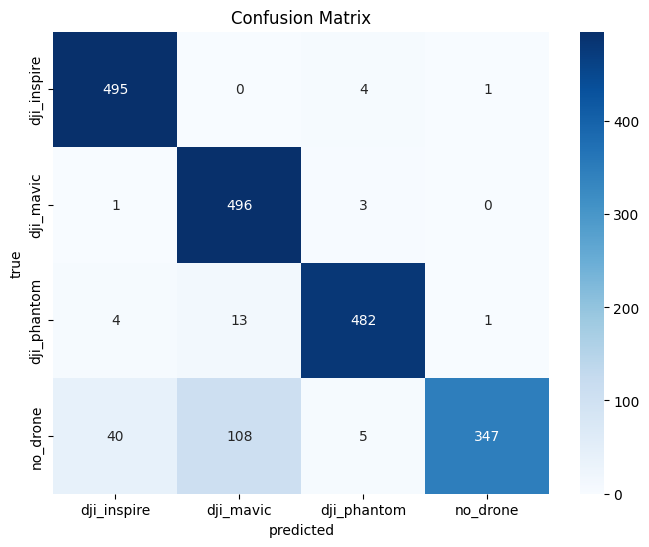

In [71]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('Confusion Matrix')
plt.show()

### random model's predictions

- denormalizing images before output

In [ ]:
def denormalize(img_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img_tensor * std + mean

In [ ]:
def show_pred(model, dataloader, class_names, num_images=6):
    model.eval()
    model.to(device)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    all_images = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(images.size(0)):
                all_images.append(images[i].cpu())
                all_preds.append(preds[i].item())
                all_labels.append(labels[i].item())

    indices = random.sample(range(len(all_images)), num_images)
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        img = denormalize(all_images[idx], mean, std)
        img = torch.clamp(img, 0, 1).permute(1, 2, 0)
        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[all_preds[idx]]}\nTrue: {class_names[all_labels[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
class_names = test_loader.dataset.classes

predicted labels comparing to the true ones:

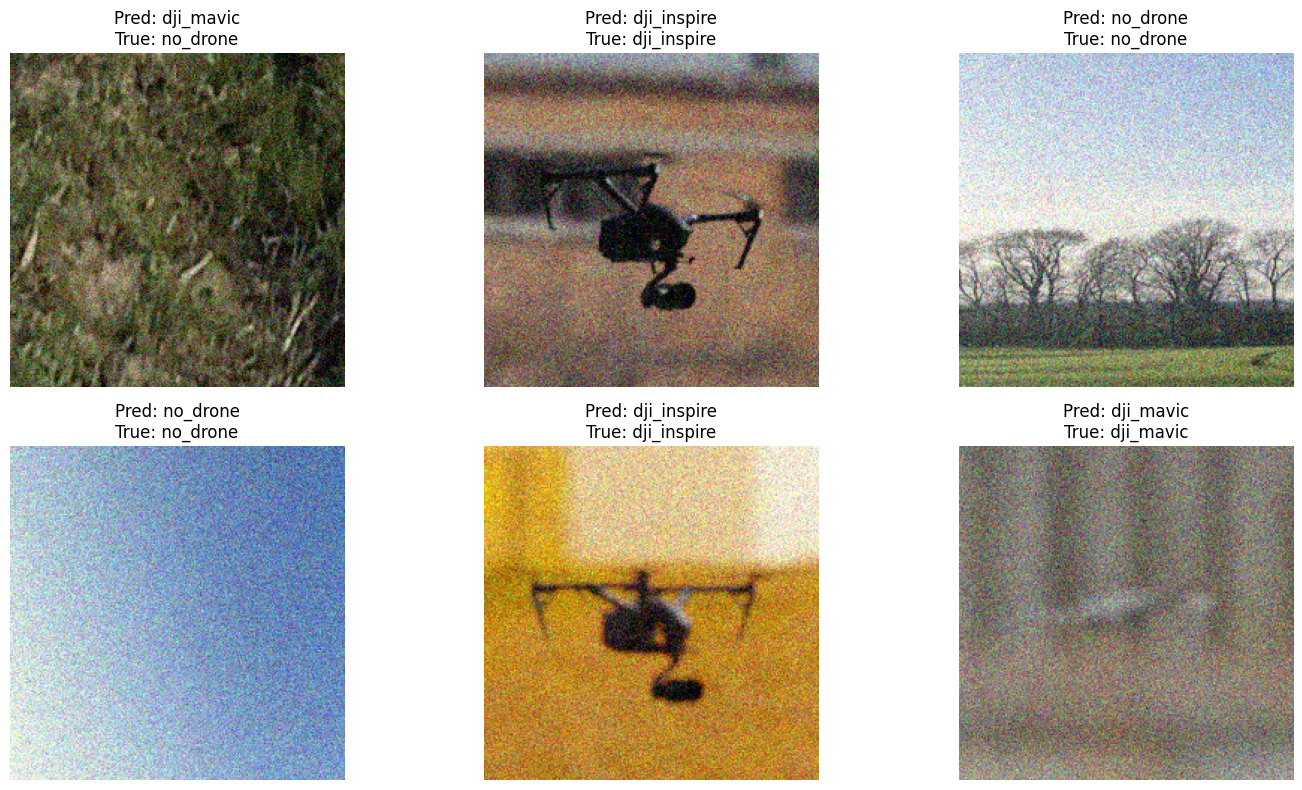

In [ ]:
show_pred(model, test_loader, class_names)

### random model's mistakes

In [ ]:
def show_misclassified(model, dataloader, class_names, num_images=6):

    model.eval()
    model.to(device)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(images.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((
                        images[i].cpu(), preds[i].item(), labels[i].item()))

    num_to_show = min(num_images, len(misclassified))
    chosen = random.sample(misclassified, num_to_show)
    plt.figure(figsize=(15, 8))
    for i, (img_tensor, pred, true) in enumerate(chosen):
        img = denormalize(img_tensor, mean, std)
        img = torch.clamp(img, 0, 1).permute(1, 2, 0)
        plt.subplot(2, (num_to_show + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

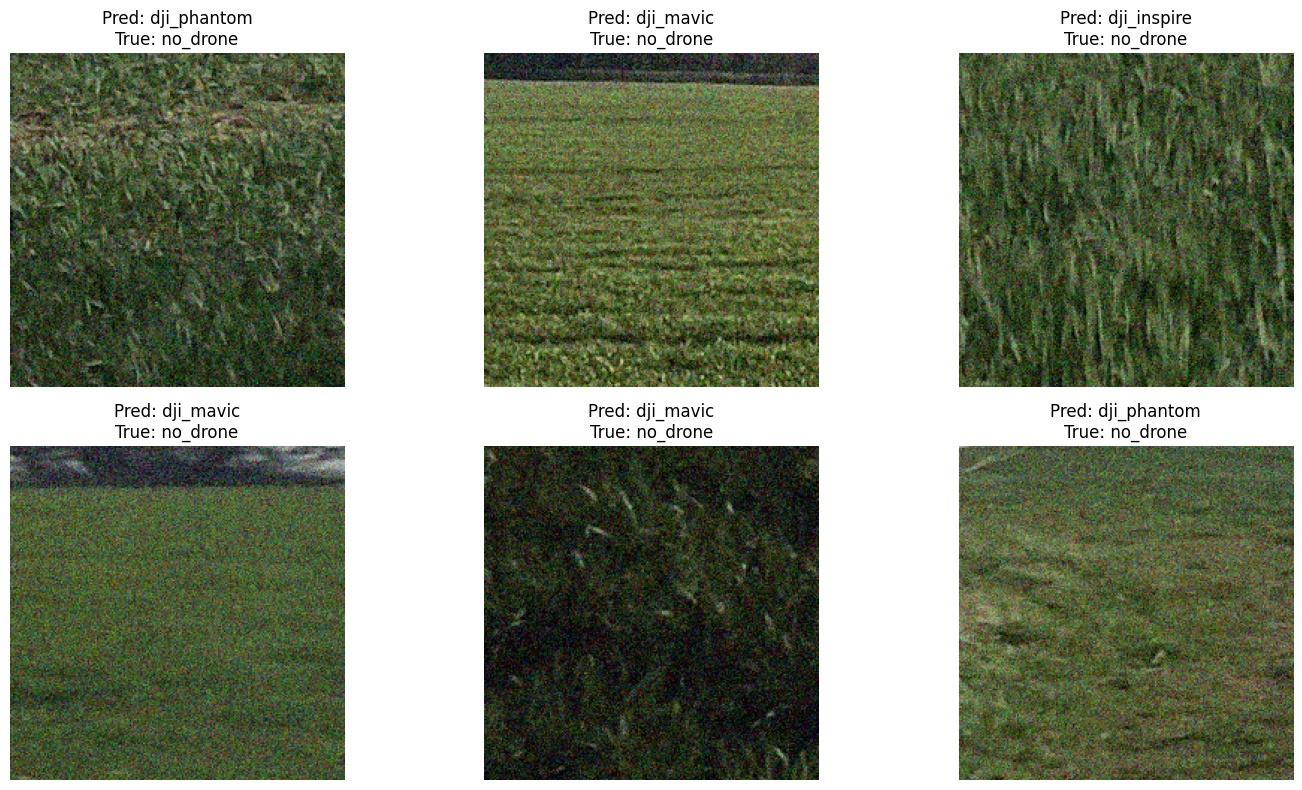

In [ ]:
show_misclassified(model, test_loader, class_names)

# conclusions

**the base model reached an accuracy of ~90% using these parameters:**

- learning rate: 0.001
- dropout: 0.04
- num of neurons on FC-layers: 512->128->64->4

**after hyperparameter tuning, the best model reached a higher accuracy of 91% on test set, with the optimized parameters:**

- learning rate: 0.0004
- dropout: 0.05
- num of neurons on FC-layers: 246->64->4

**to sum up:**

smaller learning rate helped the model train better and a bit less overfit.

simpler fully connected layers made the model more general and better on this dataset, cause as I said earlier - base model may be too heavy for this amount of data.

dropout also helped a little to prevent overfitting.

accuracy got slightlybetter –  1% higher, which means more correct predictions, anyways there won't be a huge difference in accuracy cause models architecture is quite similar and also both of models have great results.